In [ ]:
!pip install bqskit

In [ ]:
!pip install pennylane

In [ ]:
!pip install matplotlib

In [ ]:
!pip install pylatexenc

In [ ]:


circuit = QuantumCircuit.from_qasm_str("""
OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
creg c[1];
GPI(6.097008280575698) q[0];
GPI2(2.514389538449717) q[1];
GPI(0.6252981497326392) q[2];
GPI2(3.0084240523465438) q[3];
GPI2(0.951853408690569) q[0];
GPI(-1.2022653859351593) q[1];
GPI2(3.290133660649969) q[2];
GPI2(2.4266873778062323) q[3];
GPI2(0.9216859514703398) q[0];
partialMS(-25.339272560828313, -45.404552448160985, 0.6240518651504615) q[1], q[2];
GPI2(0.7334597706432365) q[3];
GPI2(0.6084655167067745) q[1];
GPI2(1.5593147610995937) q[2];
partialMS(-32.30980624120803, -63.7900344843773, 3.141592643316855) q[0], q[1];
GPI2(3.820099242744327) q[0];
GPI2(4.568689087028451) q[1];
GPI2(2.791279931687323) q[0];
GPI2(5.217314023078753) q[1];
GPI(2.9225623611397933) q[0];
GPI(6.42098399848912) q[1];
partialMS(4.624224294501004, 1.4610735494147826, 4.712388980053748) q[0], q[3];
GPI2(4.214430601377163) q[0];
GPI2(4.5923091502863365) q[3];
GPI2(3.54294855338872) q[0];
GPI2(3.0122491176086545) q[3];
GPI2(4.499523855147072) q[0];
GPI2(3.8985357931588736) q[3];
partialMS(-1.6366622250411695, 23.550458866210544, 6.288377861620754) q[0], q[2];
GPI(-3.5069189742450066) q[0];
GPI2(-1.0422187767102564) q[2];
GPI2(-10.096852129105107) q[0];
GPI2(-0.8562119079015739) q[2];
partialMS(-7.910235551018583, -0.3237944352114436, 4.712388979492994) q[0], q[2];
GPI2(-4.488570507506173) q[0];
GPI(1.9123095016686436) q[2];
GPI2(-2.650303899363517) q[0];
GPI2(2.577616957339891) q[2];
partialMS(-2.9299177655753974, 2.8070578030513955, 3.141592657979876) q[0], q[1];
GPI(2.5650878981912473) q[0];
GPI(-0.8172826889652348) q[1];
GPI2(5.4569315647336065) q[0];
GPI2(3.8834400096723876) q[1];
GPI2(5.207078470665902) q[1];
partialMS(4.274717611917433, 11.021188815889802, 7.8539816332515455) q[0], q[1];
GPI2(6.307466186593573) q[0];
GPI(0.7982054413790232) q[1];
GPI2(2.9768567035115403) q[0];
GPI2(3.1415926495997053) q[1];
GPI2(4.092832012723948) q[0];
partialMS(4.008990467883893, 5.456978170663266, 1.5707963267833938) q[0], q[3];
GPI2(1.124615337824774) q[0];
GPI(3.5138872554953373) q[3];
GPI2(2.8692663373791434) q[0];
GPI2(5.021768079297408) q[0];
measure q[0] -> c[0];
""")
circuit.draw('mpl')

In [1]:
from bqskit import Circuit, compile
from bqskit.compiler.machine import MachineModel
from bqskit.ext import qiskit_to_bqskit

import pennylane as qml
from qiskit import QuantumCircuit

import numpy as np

In [3]:
from qiskit.circuit import Gate  # Import the Gate class for custom gates
import numpy as np  # Import NumPy for numerical operations

class VirtualZGate(Gate):
    """
    Custom Virtual-Z Gate for Qiskit.

    This gate represents a virtual Z rotation and is parameterized by an angle `theta`.

    Mathematically, it performs the following unitary operation:

        U = [[exp(-i * π * theta),  0]
             [0,  exp(i * π * theta)]]+

    The `theta` parameter determines the phase shift applied to the qubit.

    Attributes:
        - theta (float): The phase rotation angle.
    """

    def __init__(self, theta):
        """
        Initialize the Virtual-Z Gate.

        Args:
            theta (float): Rotation angle for the Z gate.
        """
        super().__init__("virt_z", 1, [theta])  # Define a 1-qubit gate with a parameter

    def to_matrix(self):
        """
        Compute the unitary matrix representation of the Virtual-Z Gate.

        Returns:
            np.ndarray: The 2x2 unitary matrix corresponding to the Virtual-Z Gate.
        """
        theta = self.params[0]  # Extract the parameter (rotation angle)
        return np.array([
            [np.exp(-1j *  theta), 0],  # Phase shift for |0⟩ state
            [0, np.exp(1j *  theta)]   # Phase shift for |1⟩ state
        ])


class GPIGate(Gate):
    """
    Custom GPI(ϕ) Gate for Qiskit.

    This gate applies a phase-dependent transformation on a single qubit.

    Mathematically, it performs the following unitary operation:

        U = [[0, e^(-2πiϕ)]
             [e^(2πiϕ), 0]]

    The parameter `ϕ` defines the phase applied to the qubit.

    Attributes:
        - ϕ (float): Phase parameter.
    """

    def __init__(self, phi):
        """
        Initialize the GPI Gate.

        Args:
            phi (float): Phase shift angle.
        """
        super().__init__("gpi", 1, [phi])  # Define a 1-qubit gate with one parameter

    def to_matrix(self):
        """
        Compute the unitary matrix representation of the GPI Gate.

        Returns:
            np.ndarray: The 2x2 unitary matrix corresponding to the GPI Gate.
        """
        phi = self.params[0]  # Extract the phase parameter
        return np.array([
            [0, np.exp(-1j * phi)],
            [np.exp(1j * phi), 0]
        ])


class GPI2Gate(Gate):
    """
    Custom GPI2(ϕ) Gate for Qiskit.

    This gate applies a generalized phase transformation on a single qubit.

    Mathematically, it performs the following unitary operation:

        U = (1/√2) * [[ 1, -i e^(-2πiϕ)]
                       [-i e^(2πiϕ), 1]]

    The parameter `ϕ` defines the phase shift applied to the qubit.

    Attributes:
        - ϕ (float): Phase parameter.
    """

    def __init__(self, phi):
        """
        Initialize the GPI2 Gate.

        Args:
            phi (float): Phase shift angle.
        """
        super().__init__("gpi2", 1, [phi])  # Define a 1-qubit gate with one parameter

    def to_matrix(self):
        """
        Compute the unitary matrix representation of the GPI2 Gate.

        Returns:
            np.ndarray: The 2x2 unitary matrix corresponding to the GPI2 Gate.
        """
        phi = self.params[0]  # Extract the phase parameter
        factor = 1 / np.sqrt(2)  # Normalization factor
        exp_pos = -1j * np.exp(1j * phi)
        exp_neg = -1j * np.exp(-1j * phi)

        return factor * np.array([
            [1, exp_neg],
            [exp_pos, 1]
        ])

class FullMSGate(Gate):
    """
    Custom Full Mølmer-Sørensen (MS) Gate for Qiskit.

    This gate applies a fully entangling operation between two qubits with two phase parameters.

    Mathematically, it performs the following unitary operation:

        U = (1/√2) * [[1,  0,  0,  -i e^(-2πi (ϕ₀ + ϕ₁)) ]
                      [0,  1,  -i e^(-2πi (ϕ₀ - ϕ₁)),  0 ]
                      [0,  -i e^(2πi (ϕ₀ - ϕ₁)),  1,  0 ]
                      [-i e^(2πi (ϕ₀ + ϕ₁)),  0,  0,  1 ]]

    The parameters `ϕ₀` and `ϕ₁` control the phase shifts applied to the qubits.

    Attributes:
        - ϕ₀ (float): Phase parameter 1
        - ϕ₁ (float): Phase parameter 2
    """

    def __init__(self, phi0, phi1):
        """
        Initialize the FullMS Gate.

        Args:
            phi0 (float): First phase shift angle.
            phi1 (float): Second phase shift angle.
        """
        super().__init__("fullMS", 2, [phi0, phi1])  # Define a 2-qubit gate with 2 parameters

    def to_matrix(self):
        """
        Compute the unitary matrix representation of the FullMS Gate.

        Returns:
            np.ndarray: The 4x4 unitary matrix corresponding to the FullMS Gate.
        """
        phi0, phi1 = self.params  # Extract the phase parameters
        factor = 1 / np.sqrt(2)  # Normalization factor

        exp_14 = -1j * np.exp(-1j * (phi0 + phi1))
        exp_23 = -1j * np.exp(-1j * (phi0 - phi1))
        exp_32 = -1j * np.exp(1j * (phi0 - phi1))
        exp_41 = -1j * np.exp(1j * (phi0 + phi1))

        return factor * np.array([
            [1, 0, 0, exp_14],
            [0, 1, exp_23, 0],
            [0, exp_32, 1, 0],
            [exp_41, 0, 0, 1]
        ])


class PartialMSGate(Gate):
    """
    Custom Partial Mølmer-Sørensen (MS) Gate for Qiskit.

    This gate applies an entangling operation with two phase parameters and an additional
    rotation parameter `θ` controlling the entanglement strength.

    Mathematically, it performs the following unitary operation:

        U = [[ cos(πθ),  0,  0,  -i e^(-2πi (ϕ₀ + ϕ₁)) sin(πθ) ]
             [ 0,  cos(πθ),  -i e^(-2πi (ϕ₀ - ϕ₁)) sin(πθ),  0 ]
             [ 0,  -i e^(2πi (ϕ₀ - ϕ₁)) sin(πθ),  cos(πθ),  0 ]
             [ -i e^(2πi (ϕ₀ + ϕ₁)) sin(πθ),  0,  0,  cos(πθ) ]]

    The parameters `ϕ₀`, `ϕ₁`, and `θ` control the entangling operation.

    Attributes:
        - ϕ₀ (float): Phase parameter 1
        - ϕ₁ (float): Phase parameter 2
        - θ (float): Rotation parameter (controls entanglement strength)
    """

    def __init__(self, phi0, phi1, theta):
        """
        Initialize the PartialMS Gate.

        Args:
            phi0 (float): First phase shift angle.
            phi1 (float): Second phase shift angle.
            theta (float): Rotation parameter.
        """
        super().__init__("partialMS", 2, [phi0, phi1, theta])  # Define a 2-qubit gate with 3 parameters

    def to_matrix(self):
        """
        Compute the unitary matrix representation of the PartialMS Gate.

        Returns:
            np.ndarray: The 4x4 unitary matrix corresponding to the PartialMS Gate.
        """
        phi0, phi1, theta = self.params  # Extract parameters
        cos_theta = np.cos(theta/2)
        sin_theta = np.sin(theta/2)

        e_pos = -1j * np.exp(1j * (phi0 + phi1))
        e_neg = -1j * np.exp(-1j * (phi0 + phi1))
        e_diff_pos = -1j * np.exp(1j * (phi0 - phi1))
        e_diff_neg = -1j * np.exp(-1j * (phi0 - phi1))

        return np.array([
            [cos_theta, 0, 0, e_neg * sin_theta],
            [0, cos_theta, e_diff_neg * sin_theta, 0],
            [0, e_diff_pos * sin_theta, cos_theta, 0],
            [e_pos * sin_theta, 0, 0, cos_theta]
        ])


In [4]:
# all parameters are supposed to be 2pi periodic
def normalize_param(param):
    new_param = param
    while new_param > 2 * np.pi:
        new_param -= 2 * np.pi
    while new_param < 0:
        new_param += 2 * np.pi
    return new_param


def normalize_theta(param):
    new_param = param
    while new_param > np.pi / 2:
        new_param -= np.pi / 2
    while new_param < 0:
        new_param += np.pi / 2
    return new_param
def load_qasm(file_path):
    """
    Load an OpenQASM 2.0 file and construct a Qiskit QuantumCircuit.

    This function:
    - Reads a QASM file line by line.
    - Parses standard gates like `rx`, `ry`, `rz`, `cx`, etc.
    - Replaces `GPI`, `GPI2`, `virt_z`, `fullMS`, and `partialMS` with their custom gate definitions.

    Args:
        file_path (str): Path to the QASM file.

    Returns:
        QuantumCircuit: A Qiskit circuit containing the parsed gates.
    """

    # Read the QASM file
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Determine the number of qubits from qreg
    num_qubits = 0
    for line in lines:
        if "qreg q[" in line:
            num_qubits = int(line.split("[")[1].split("]")[0])

    # Initialize a QuantumCircuit
    qc = QuantumCircuit(num_qubits)

    # Parse QASM lines
    for line in lines:
        tokens = line.strip().split()
        if not tokens or tokens[0] in {"OPENQASM", "include", "qreg"}:
            continue  # Skip metadata lines

        gate, *args = tokens
        if "(" in gate:  # Parameterized gate
            gate_name, param = gate.split("(")
            # TWO qubit parametrized
            if gate_name == "fullMS":
                q1 = int(args[1].replace("q[", "").replace("],", "").replace("];", ""))
                q2 = int(args[2].replace("q[", "").replace("];", ""))
                phi1 = normalize_param(float(param.split(",")[0]))
                phi2 = normalize_param(float(args[0].split(")")[0]))
                qc.append(FullMSGate(phi1, phi2), [q1, q2])
            elif gate_name == "partialMS":
                q1 = int(args[2].replace("q[", "").replace("],", "").replace("];", ""))
                q2 = int(args[3].replace("q[", "").replace("];", ""))
                phi1 = normalize_param(float(param.split(",")[0]))
                phi2 = normalize_param(float(args[0].split(",")[0]))
                theta = normalize_theta(float(args[1].split(")")[0]))
                qc.append(PartialMSGate(phi1, phi2, theta), [q1, q2])
            elif gate_name == "ZZ":
                q1 = int(args[0].replace("q[", "").replace("],", "").replace("];", ""))
                q2 = int(args[1].replace("q[", "").replace("];", ""))
                theta = normalize_theta(float(param.split(")")[0]))
                qc.rzz(theta,q1,q2)
            else:
                param = normalize_param(float(param.rstrip(");")))

                qubit_args = [int(q.replace("q[", "").replace("],", "").replace("];", "")) for q in args]

                if gate_name == "virt_z":
                    qc.append(VirtualZGate(param), [qubit_args[0]])  # Apply custom Virtual-Z gate
                elif gate_name == "GPI":
                    qc.append(GPIGate(param), [qubit_args[0]])  # Apply custom GPI gate
                elif gate_name == "GPI2":
                    qc.append(GPI2Gate(param), [qubit_args[0]])  # Apply custom GPI2 gate
                elif hasattr(qc, gate_name):  # Check if the gate exists in Qiskit
                    getattr(qc, gate_name)(param, qubit_args[0])

        elif gate == "cx":  # CNOT gate
            q1 = int(args[0].replace("q[", "").replace("],", "").replace("];", ""))
            q2 = int(args[1].replace("q[", "").replace("];", ""))
            qc.cx(q1, q2)

    return qc  # Return the constructed QuantumCircuit

In [7]:
qc_transpiled = load_qasm("circuit.qasm")


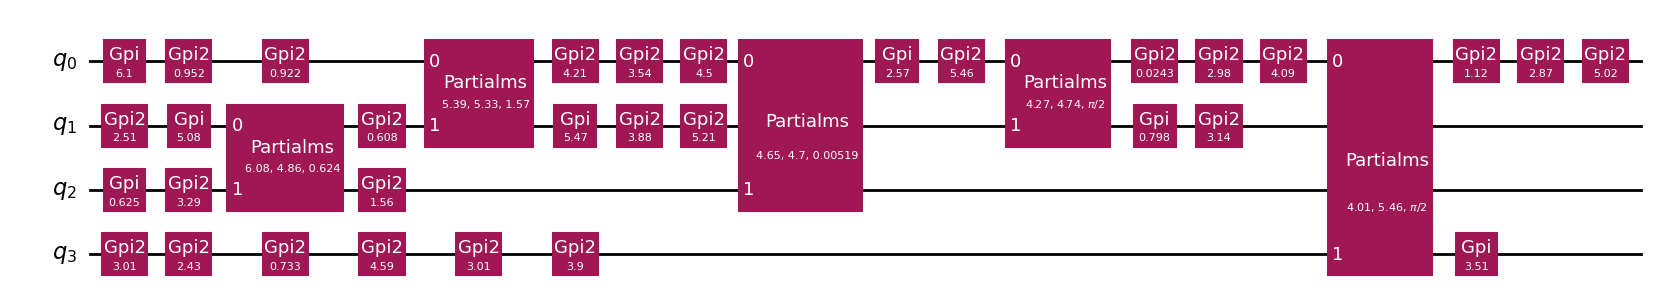

In [8]:
qc_transpiled.draw('mpl')